# Using Python to Create Pivot Tables, Output Files, and Graphs:
## A Python Tutorial Program

By Kenneth Burchfiel

This file, its input sources, and its output are all released under the MIT license.

In this program, I will demonstrate how Python can be used to turn raw data into pivot tables and graphs. The program uses a fictional scenario and simulated data, but the concepts it presents should prove useful in a number of basic data analysis applications.

For a more detailed introduction, please see my related blog post. \[Blog post forthcoming! I will add a link once it's ready.\].

## Scenario:
(Note: both the scenario and the data presented in this program are fictional.)

Orange Valley School District (OVSD) is piloting an after-school math program called Code the Concepts in each of its 8 high schools. This program aims to teach students relevant math skills through programming and computer science applications, and is available in grades 9-12.

Although the district believes that the programming knowledge taught in this course is highly valuable in itself, it also wants to evaluate the impact, if any, this program has on students' math skills. The means of evaluating the math skills will be the Higher Grades Math Assessment (HGMA), a test administered at the beginning and end of each school year.

Let's say that I am an analyst tasked with evaluating this HGMA data. In this notebook, I will show how I can use Python for this type of analytics project.

I will first import a number of libraries:

In [1]:
import time

start_time = time.time()

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from adjustText import adjust_text


## Part 1: Creating simulated data for analysis

I will first need to create the fictional data that I will 'analyze' in the following program. Let's say that OVSD has 8 high schools serving grades 9-12, with around 120 students in each grade. About half of these students will be enrolled in Code the Concepts and the other half will not. Therefore, to store HGMA data for each of these students, I will need to create a Pandas DataFrame with around 3840 rows (8 high schools \* 4 grades \* 120 students per grade) for the beginning-of-year HGMA score results, and another equally sized DataFrame for the end-of-year results.

One relatively efficient strategy for building this table is to randomly assign integers representing schools, grades, and enrollment values to each student in the table. These integers can then be replaced with string values. Meanwhile, the test score variable will be a combination of random chance and effects from the school, grade, and Code the Concepts enrollment variables.


I will first create an empty DataFrame for the start-of-year data:

In [2]:
df_scores_start = pd.DataFrame(index=np.arange(1,3841),columns=['School','Grade','Enrolled','Time','Score'])
df_scores_start.index.rename('Student_ID',inplace=True)
df_scores_start

,School,Grade,Enrolled,Time,Score
Student_ID,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3836,NaN,NaN,NaN,NaN,NaN
3837,NaN,NaN,NaN,NaN,NaN
3838,NaN,NaN,NaN,NaN,NaN


Next, I will use both random numbers and direct assignment to populate the values in this DataFrame.

In [3]:
rng = np.random.default_rng(1337) # ;)

In [4]:
for i in range (0, len(df_scores_start)): 
    df_scores_start.loc[df_scores_start.index[i],'School'] = rng.integers(0,8) # Returns integers between 1 and 8 to represent each of the 8 schools in the district. See https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.integers.html
    df_scores_start.loc[df_scores_start.index[i],'Grade'] = rng.integers(9,13)
    df_scores_start.loc[df_scores_start.index[i],'Enrolled'] = rng.integers(0,2)
    df_scores_start.loc[df_scores_start.index[i],'Score']= rng.integers(30,80)    

df_scores_start['Time'] = '2018_9' # 2018_9 = September 2018, the start of the academic year; 2019_5 = May 2019, the end of the academic year.
df_scores_start['Count'] = 1 # Creating a row with the value 1 for every student will make it easier to use np.sum to return record counts within pivot tables.
school_list = ['Westwood', 'Fair Lake', 'Eagle', 'East River', 'Bayville', 'Cardinal', 'Olive', 'Central'] # The names of each high school in the (fictional) district.

for i in range(len(df_scores_start)):
    df_scores_start.loc[df_scores_start.index[i],'School'] = school_list[df_scores_start.loc[df_scores_start.index[i],'School']]# This line replaces the integer corresponding to each school with the school in school_list whose index equals that integer.
    if df_scores_start.iloc[i,2] == 1: # Converting the Enrolled column from numerical values to string values. Using .iloc produces shorter lines of code than the above format, but it is also less intuitive (as numbers are used in place of column labels).
        df_scores_start.iloc[i,2] = 'Yes'
    else:
        df_scores_start.iloc[i,2] = 'No'


In [5]:
df_scores_start

,School,Grade,Enrolled,Time,Score,Count
Student_ID,,,,,,
1,Bayville,12,Yes,2018_9,39,1
2,Bayville,12,No,2018_9,77,1
3,Eagle,12,No,2018_9,35,1
4,Westwood,9,No,2018_9,47,1
5,Eagle,10,Yes,2018_9,74,1
...,...,...,...,...,...,...
3836,Olive,10,Yes,2018_9,34,1
3837,Bayville,10,Yes,2018_9,30,1
3838,Cardinal,11,No,2018_9,59,1


Next, I will create a DataFrame for the end-of-year data. This table will be a copy of the start-of-year DataFrame, except that the Score column will have new values from the HGMA end-of-year test results. These results will be based on the beginning-of-year data, but will also reflect positive effects of the Code the Concepts program for certain schools and classes. 

In [6]:
df_scores_end = df_scores_start.copy() # copy() is required here in order to prevent changes to df_scores_end from affecting df_scores_start.
school_list = ['Fair Lake', 'Eagle', 'Bayville', 'Central']
grade_list = [10, 12]
for i in range(len(df_scores_end)):    
    if df_scores_end.loc[df_scores_end.index[i],'Enrolled'] == 'Yes':
        if df_scores_end.loc[df_scores_end.index[i],'School'] in school_list:
            df_scores_end.loc[df_scores_end.index[i],'Score'] += 3+rng.integers(0,8) # As a result of this line, Code the Concepts students who attend one of the schools in school_list will earn a higher HGMA score than will other students.
        if df_scores_end.loc[df_scores_end.index[i],'Grade'] in grade_list:  
            df_scores_end.loc[df_scores_end.index[i],'Score'] += 5+rng.integers(0,10) # Similarly, Code the Concepts students who are currently in one of the grades in grade_list will earn a higher HGMA score than will other students. 
    df_scores_end.loc[df_scores_end.index[i],'Score'] += rng.integers(-5,10)  # This line creates allows for some random (but generally positive) change in each student's HGMA score.  
    df_scores_end.loc[df_scores_end.index[i],'Score'] = min(df_scores_end.loc[df_scores_end.index[i],'Score'],100) # Keeps all scores below 100
df_scores_end['Time'] = '2019_5'
df_scores_end

,School,Grade,Enrolled,Time,Score,Count
Student_ID,,,,,,
1,Bayville,12,Yes,2019_5,54,1
2,Bayville,12,No,2019_5,75,1
3,Eagle,12,No,2019_5,39,1
4,Westwood,9,No,2019_5,49,1
5,Eagle,10,Yes,2019_5,92,1
...,...,...,...,...,...,...
3836,Olive,10,Yes,2019_5,45,1
3837,Bayville,10,Yes,2019_5,54,1
3838,Cardinal,11,No,2019_5,68,1


These start-of-year and end-of-year DataFrames can then be combined into a single DataFrame using pd.concat:

In [7]:
df_scores = pd.concat([df_scores_start.copy(),df_scores_end.copy()])
df_scores.sort_index(inplace=True)
df_scores

,School,Grade,Enrolled,Time,Score,Count
Student_ID,,,,,,
1,Bayville,12,Yes,2018_9,39,1
1,Bayville,12,Yes,2019_5,54,1
2,Bayville,12,No,2018_9,77,1
2,Bayville,12,No,2019_5,75,1
3,Eagle,12,No,2018_9,35,1
...,...,...,...,...,...,...
3838,Cardinal,11,No,2018_9,59,1
3839,Eagle,12,Yes,2019_5,52,1
3839,Eagle,12,Yes,2018_9,33,1


In [8]:
df_scores['Grade'] = pd.to_numeric(df_scores['Grade']) # These two lines convert grade and school data to numerical values.
df_scores['Score'] = pd.to_numeric(df_scores['Score'])
df_scores.dtypes

School      object
Grade        int64
Enrolled    object
Time        object
Score        int64
Count        int64
dtype: object

In [9]:
df_scores.to_excel('scores_by_program_enrollment.xlsx')

## Part 2: Analysis function definitions and data import

With the simulated data created and exported to Excel, I can now start writing code for my analysis program.

The following function appends tables to an output CSV file, and also allows a title to be placed above each table. If the output file (specified by the file_path variable) does not yet exist, the function will create it automatically.

In [10]:
def append_csv(file_path,title_string,table): # Table = dataframe to append to the CSV; title_string = header to place above table
    with open(file_path,'a',newline='') as file_to_write:
        writer = csv.writer(file_to_write)
        writer.writerows(['\n','\n']) # Inserts two spaces in the CSV file after the above table for improved readability
        writer.writerow([title_string]) # The list notation is necessary; otherwise the text will be input one letter per cell!
    table.to_csv(file_path, mode='a')

output_file_path = 'output_tables.csv'

The above function is designed to append, rather than overwrite, output_tables.csv. As a result, if the program is run multiple times, duplicate tables will be appended to the program. Therefore, to avoid this issue, the line below overwrites any pre-existing output_tables.csv with a blank file, and also appends a title to that file. 

In [11]:
with open(output_file_path,'w',newline='') as file_to_write: # Will create this file if it does not already exist (or will overwrite it if it does exist)
    writer = csv.writer(file_to_write)
    writer.writerow(['HGMA Score Data for OVSD High Schoolers'])

The following function builds off Pandas' pivot_table function to create a pivot table with subtotal rows. This function will make it easier to evaluate both individual grade data and grouped data for schools and enrollment conditions.

In [12]:
def pivot_with_subtotals(df, values, index, aggfunc, levels): # 'values', 'index', and 'aggfunc' will be fed directly into pivot_table below. 'levels' refers to the number of levels to add into the pivot table. The order of the elements in the 'index' list is important, since each set of subtotal rows will be created by deleting the rightmost element of index.
    
    # For example, suppose that 'index' equals ['Enrolled', 'Time', 'School', 'Grade'], and 'levels' equals 3. This means that the first pivot table will use 'Enrolled', 'Time', 'School', and 'Grade' as its index values; the second pivot table will use 'Enrolled', 'Time', and 'School' (thus grouping the values by grade); and the third table will use 'Enrolled' and 'Time' (thus grouping by school and grade and allowing totals to be calculated for all enrolled and non-enrolled students). The function concatenates each of these tables together, producing one unified pivot table.

    modified_index = index.copy() # modified_index will store the index values used in each iteration of the pivot_table function below.  
    pivot_combined = pd.DataFrame() # This empty DataFrame will be populated with output from the pivot table.
    for i in range(levels): # The higher the levels value, the more subtotal levels will be added into the pivot table.
        pivot_individual = pd.pivot_table(data = df, values=values, index=modified_index, aggfunc=aggfunc) # See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html
        pivot_individual.reset_index(inplace=True) # Resetting the index makes it easier to concatenate different pivot tables on top of each other.
        pivot_combined = pd.concat([pivot_combined,pivot_individual])
        del(modified_index[-1]) # Deletes the final element in modified_index, allowing the next run of pivot_table to create a subtotal row. 
    pivot_combined.columns = pivot_combined.columns.to_flat_index() # pivot_table() may output its results as a multindex. For the purposes of this program, I prefered to work with simple indices, so I used to_flat_index() to convert the multindex-formatted columns to a flat index.
    for column in pivot_combined.columns: # When columns are converted from a multindex to a flat index, the result is stored as a tuple. The following lines of code convert each tuple to a string. For instance, the code will convert the tuple ('count', 'Score') to count_Score.
        #print(type(column))
        if isinstance(column, tuple) == True:
            if len(column[1]) > 0:
                pivot_combined.rename(columns={column:column[0]+'_'+column[1]},inplace=True) # [0] and [1] represent the two elements of the tuple
            else: # Some tuples are in the format ('Column_name',''). In this case, there's no need to add an underscore after the first tuple element, so the following line of code simply replaces the tuple with its first element.
                pivot_combined.rename(columns={column:column[0]},inplace=True)
    # Currently, the combined DataFrame has NaN values in cells within columns that were not included in the subtotal/total rows. The following for loop changes these cells to 'Total'. The for loop only covers colunms included in index_i in order not to alter values columns.
    for i in range(len(index)):
        print(pivot_combined.columns[i])
        pivot_combined.fillna(value={pivot_combined.columns[i]:'Total'},axis=0,inplace=True) # See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html . Axis=0 may not be necessary.
    pivot_combined.reset_index(drop=True,inplace=True)
    return pivot_combined



In the real world, the data generated earlier and stored in df_scores might exist in the form of an Excel or CSV file. The following line imports df_scores from Excel into a DataFrame.

In [13]:
df_scores = pd.read_excel('scores_by_program_enrollment.xlsx',index_col='Student_ID')
df_scores

,School,Grade,Enrolled,Time,Score,Count
Student_ID,,,,,,
1,Bayville,12,Yes,2018_9,39,1
1,Bayville,12,Yes,2019_5,54,1
2,Bayville,12,No,2018_9,77,1
2,Bayville,12,No,2019_5,75,1
3,Eagle,12,No,2018_9,35,1
...,...,...,...,...,...,...
3838,Cardinal,11,No,2018_9,59,1
3839,Eagle,12,Yes,2019_5,52,1
3839,Eagle,12,Yes,2018_9,33,1


## Part 3: Creating a pivot table using pivot_with_subtotals formula

In [14]:
pd.set_option('display.max_rows',200)

The following code block creates a pivot table (based off df_scores) with both individual and subtotal rows. The comments in the function definition above explain how the levels and index arguments work together to generate subtotal values.

In [15]:
df_scores_pivot_combined = pivot_with_subtotals(df = df_scores, values = 'Score', index = ['Enrolled', 'Time', 'School', 'Grade'], aggfunc = ['mean', 'count'], levels=3)

df_scores_pivot_combined.sort_values(['School','Grade','Enrolled','Time'],inplace=True) # This sort is important for correctly drawing each set of graphs later in the program.
df_scores_pivot_combined.reset_index(drop=True,inplace=True) # Resets the index so that it corresponds with the newly sorted rows.
append_csv('output_tables.csv','Pivot Table for Line Graphs',df_scores_pivot_combined) # Outputting this table to a .csv file will make it easier to share the results with individuals who don't have access to a code editor.

df_scores_pivot_combined

Enrolled
Grade
School
Time


,Enrolled,Grade,School,Time,count_Score,mean_Score
0,No,9.0,Bayville,2018_9,50,54.660000
1,No,9.0,Bayville,2019_5,50,58.040000
2,Yes,9.0,Bayville,2018_9,52,56.096154
3,Yes,9.0,Bayville,2019_5,52,64.038462
4,No,10.0,Bayville,2018_9,59,52.050847
5,No,10.0,Bayville,2019_5,59,53.542373
6,Yes,10.0,Bayville,2018_9,56,53.232143
7,Yes,10.0,Bayville,2019_5,56,70.125000
8,No,11.0,Bayville,2018_9,56,56.785714
9,No,11.0,Bayville,2019_5,56,58.500000


The above table shows the mean scores for each grade in each school as a function of their Code the Concepts enrollment. However, it also includes subtotal rows that show the mean scores for each school, still grouped by enrollment status, along with rows showing the mean scores for each enrollment status. These subtotal rows provide better insight into how various groups of students performed.

## Part 4: Adding data from this pivot table to a dashboard with an alternate format

The above table will prove useful for the grouped line charts to be created below. However, suppose that there is also an online dashboard that uses a different format than this table. It would be cumbersome and time-consuming to copy and paste the individual cells into the new dashboard; however, using Pandas' query() function, I can automate the reformatting process.

In the following blocks of code, I will create a copy of this online dashboard in DataFrame form (df_dashboard), then run a for loop that copies the relevant data from df_scores_pivot_combined into df_dashboard. 

In [16]:
# Step 1: initialize the new DataFrame based on the format of the online dashboard

df_dashboard = pd.DataFrame(columns=['School','Time','E_9','E_10','E_11','E_12','E_Total', 'NE_9', 'NE_10', 'NE_11', 'NE_12', 'NE_Total'])
df_dashboard['School'] = ['Westwood', 'Westwood', 'Fair Lake', 'Fair Lake', 'Eagle', 'Eagle', 'East River', 'East River', 'Bayville', 'Bayville', 'Cardinal', 'Cardinal', 'Olive', 'Olive', 'Central', 'Central', 'Total', 'Total'] # There will be two rows for each school, one for each time period

for i in range(0,len(df_dashboard),2): # Adds the time values into each pair of school rows.
    df_dashboard.iloc[i,1] = '2018_9'
    df_dashboard.iloc[i+1,1] = '2019_5'
     

df_dashboard

,School,Time,E_9,E_10,E_11,E_12,E_Total,NE_9,NE_10,NE_11,NE_12,NE_Total
0,Westwood,2018_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Westwood,2019_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fair Lake,2018_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fair Lake,2019_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Eagle,2018_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Eagle,2019_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,East River,2018_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,East River,2019_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Bayville,2018_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bayville,2019_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This format stores grades and enrollment statuses together within columns, rather than within rows. To convert the data in df_scores_pivot_combined into this new format, I will create a for loop that makes heavy use of Pandas' df.query() function.

For each row in df_dashboard, the following for loop first stores that row's school and time values as variables. It then goes through each column of df_dashboard where mean values are to be stored, and, using the df.query() function, finds the correct mean value within df_scores_pivot_combined to enter into the row-column pair within df_dashboard. It then assigns this mean value to the row-column pair.

Because the Total rows have less information available, the for loop only looks for certain data points in order to avoid errors.

In [17]:
if df_scores_pivot_combined.columns[5] == 'mean_Score': # if column 5 of df_scores_pivot_combined doesn't contain the mean values, then the for loop won't retrieve the incorrect values; an exception is raised to prevent this.
    for i in range(len(df_dashboard)):
        # print('Now on row',i) # for debugging
        curr_school = df_dashboard.loc[df_dashboard.index[i],'School']
        curr_time = df_dashboard.iloc[i,1] # Used .loc for curr_school and .iloc for curr_time to demonstrate two ways for accessing these values
        if curr_school != 'Total':
            df_dashboard.loc[df_dashboard.index[i],'E_9'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 9 & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'E_10'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 10 & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'E_11'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 11 & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'E_12'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 12 & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'E_Total'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 'Total' & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_9'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 9 & Enrolled == 'No'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_10'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 10 & Enrolled == 'No'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_11'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 11 & Enrolled == 'No'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_12'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 12 & Enrolled == 'No'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_Total'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 'Total' & Enrolled == 'No'").iloc[0,5]
        else:
            df_dashboard.loc[df_dashboard.index[i],'E_Total'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 'Total' & Enrolled == 'Yes'").iloc[0,5]
            df_dashboard.loc[df_dashboard.index[i],'NE_Total'] = df_scores_pivot_combined.query("Time == @curr_time & School == @curr_school & Grade == 'Total' & Enrolled == 'No'").iloc[0,5]
            
else:
    raise RuntimeError("Columns not oriented correctly") # https://docs.python.org/3/library/exceptions.html

append_csv('output_tables.csv','Table for Online Dashboard',df_dashboard) # Append_csv stores this table below the earlier export of df_scores_pivot_combined.

df_dashboard

,School,Time,E_9,E_10,E_11,E_12,E_Total,NE_9,NE_10,NE_11,NE_12,NE_Total
0,Westwood,2018_9,56.301887,53.47541,56.323077,52.246154,54.520492,56.739726,52.493151,54.45,52.896552,54.200758
1,Westwood,2019_5,57.264151,64.606557,58.246154,63.015385,60.893443,58.876712,55.054795,56.383333,55.189655,56.443182
2,Fair Lake,2018_9,51.171875,55.639344,54.42029,52.2,53.34749,54.71875,54.510638,54.918033,52.803279,54.227468
3,Fair Lake,2019_5,59.75,74.836066,63.797101,69.323077,66.783784,56.8125,56.340426,56.442623,54.393443,55.987124
4,Eagle,2018_9,53.224138,54.619048,50.764706,53.135593,52.883065,54.888889,54.897059,54.42623,54.337349,54.630282
5,Eagle,2019_5,61.534483,72.857143,59.823529,70.372881,66.044355,56.486111,56.970588,56.885246,56.301205,56.633803
6,East River,2018_9,59.145455,56.779661,56.368421,52.409091,56.012658,48.777778,55.181818,55.136364,54.636364,53.728507
7,East River,2019_5,61.509091,67.864407,59.315789,63.757576,63.189873,50.733333,58.0,58.106061,56.472727,56.171946
8,Bayville,2018_9,56.096154,53.232143,55.157895,54.693548,54.770925,54.66,52.050847,56.785714,52.95,54.048889
9,Bayville,2019_5,64.038462,70.125,63.982456,70.967742,67.418502,58.04,53.542373,58.5,53.916667,55.875556


The values above, having been exported to the output_tables.csv file, could then easily be copied and pasted into the online dashboard, although some sorting would be necessary. This saves a great deal of time over copying and pasting in individual values or trying to get formula references to line up.

## Part 5: Creating grouped line charts for each school

The data is now in two useful formats. However, it is hard to evaluate the Code the Concepts program by looking at the data tables alone. As a result, I will visualize these numbers using a series of line graphs.

First, I will make a set of line graphs for each of the 8 schools. Each of these graphs will show the changes in HGMA scores for students in all four grades and in both enrollment conditions (enrolled and non-enrolled), displaying 16 lines in total. Next, I will create a graph showing just the changes for all enrolled students and all non-enrolled students.

The for loops that create each of these graphs are quite long, and there are surely opportunities to refactor the code to make it leaner. However, I will try to make the code more understandable through comments.

First, I will create a function for plotting (1) a line and (2) separately-colored markers at the end of each line.

In [18]:
def plot_line(xpoints, ypoints, color, line_label='_', point_label_1 = '_', point_label_2 = '_' ): # X and Y points need to be in a list format; if they derive from a DataFrame, apply list() to them beforehand. Each list should have only two points.
    # Matplotlib documentation notes that "Specific lines can be excluded from the automatic legend element selection by defining a label starting with an underscore" (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html), which is why '_' is used as the default label.
    # print("x values:",xpoints) # for debugging
    # print("y values:",ypoints)
    plt.plot(xpoints, ypoints, linestyle='solid',label=line_label, linewidth=2,color=color)
    plt.plot(xpoints[0], ypoints[0],'og',label=point_label_1) # Plots a data point on the left of the line. See https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    plt.plot(xpoints[1], ypoints[1],'ob',label=point_label_2) # Plots a data point on the right of the line.

In [20]:
df_scores_pivot_combined.head() # When creating graphs based on a DataFrame, I find it useful to keep a copy of the first few rows of the DataFrame above the graph code for reference.

,Enrolled,Grade,School,Time,count_Score,mean_Score
0,No,9.0,Bayville,2018_9,50,54.660000
1,No,9.0,Bayville,2019_5,50,58.040000
2,Yes,9.0,Bayville,2018_9,52,56.096154
3,Yes,9.0,Bayville,2019_5,52,64.038462
4,No,10.0,Bayville,2018_9,59,52.050847


In [21]:
if df_scores_pivot_combined.columns[5] != 'mean_Score':
    print("Wut")

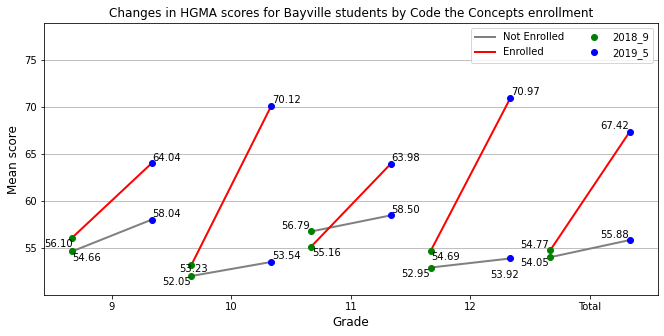

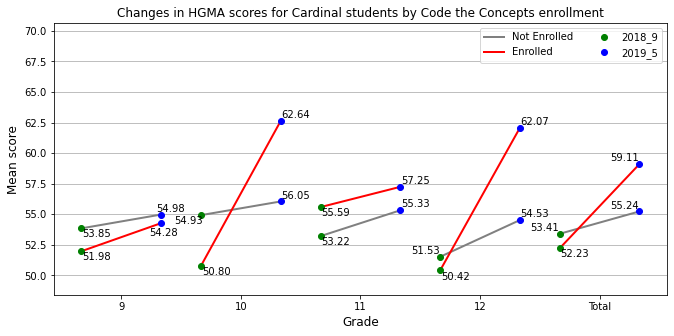

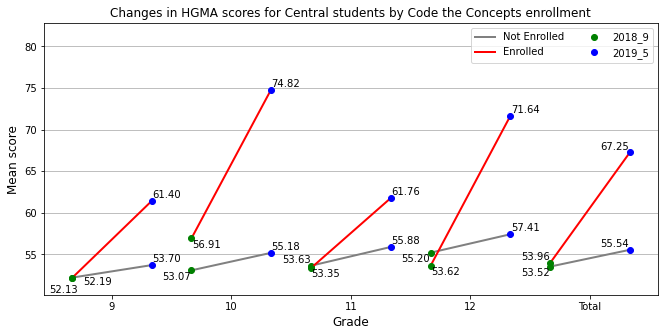

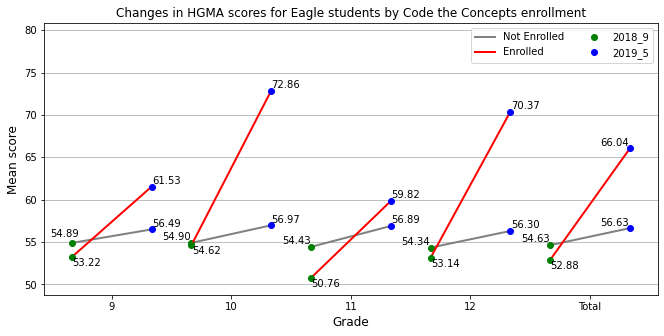

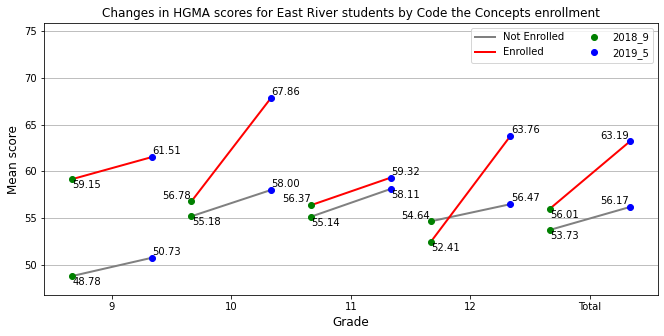

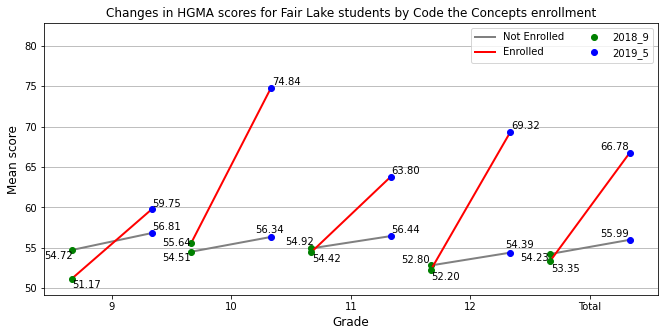

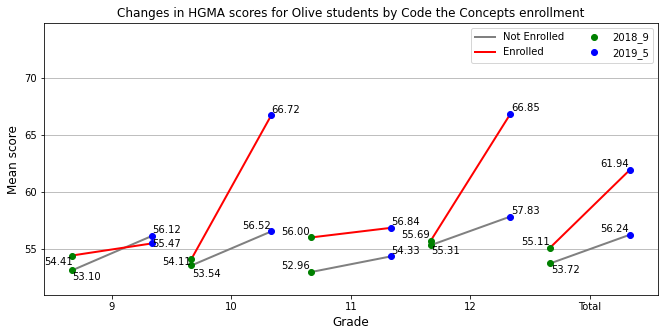

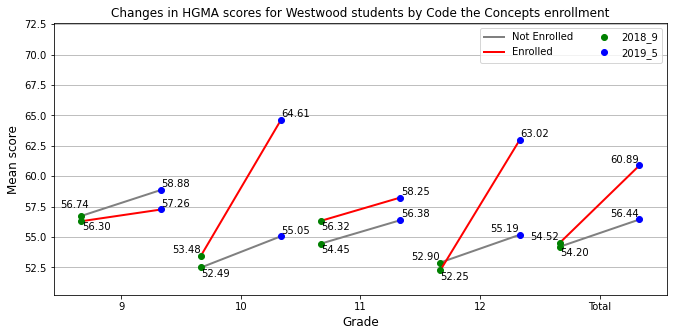

In [22]:
data_source = df_scores_pivot_combined # Giving this data_table a shorter variable name makes the code more readable and, more importantly, makes it easy to replace this DataFrame with a different one.

start_list = [0, 20, 40, 60, 80, 100, 120, 144] # These numbers list the zero-indexed row numbers where each set of high school data begins. For instance, the data for Bayville starts on row 0, whereas the data for Cardinal starts on row 20. 

# The following lists will be used for data checking purposes; their purpose will become clearer soon.
expected_enrollment_order = []
for a in range(5): # I like to avoid using "i" in more than one for loop within a code block, even if the for loops are not nested.
    expected_enrollment_order.append("No")
    expected_enrollment_order.append("No")
    expected_enrollment_order.append("Yes")
    expected_enrollment_order.append("Yes")
    # Returns a list with 20 elements in the following pattern: ['No', 'No', 'Yes', 'Yes', 'No', 'No', . . . ]. This is the expected pattern of the Enrolled values in the data source.

expected_time_order = []
for b in range (10):
    expected_time_order.append("2018_9")
    expected_time_order.append("2019_5")
    # Returns a list with 20 elements in the following pattern: ['2018_9', '2019_5', '2018_9', '2019_5', . . . ] This is the expected order of the Time values in the data source.

expected_grade_order = []
for c in range(9,14,1):
    for d in range(4):
        if c == 13:
            expected_grade_order.append('Total')
        else:
            expected_grade_order.append(c)
        # Returns the following list: [9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 'Total', 'Total', 'Total', 'Total'].         

if data_source.columns[5] != 'mean_Score':
    raise RuntimeError("score data in incorrect column") # Raises an error if the 6th column does not contain mean score data, which would result in incorrect graphs.

for x in range (0,len(start_list),1): # This for loop iterates over each value in start_list, then uses those values as reference points for drawing each graph. 
    i = start_list[x] # i represents the first of all rows in the DataFrame that refer to the current school. Other row values will be stated with reference to this row (e.g. i+3 for the 4th row). Each school is represented by 20 rows of data, so the code will utilize rows i to i+19 for each school.

    # Data checking: 
    # Before running the graphs, it is important to ensure that the data is sorted appropriately. Otherwise, the graphs will display the wrong data, and this may not be immediately apparent. Therefore, the following lines of code employ for loops to verify that the data is in the expected order. If the data is not in the proper order, a value error will be raised to prevent the function from returning incorrect charts. 
    if list(data_source.iloc[i:i+20,0]) != expected_enrollment_order:
        raise RuntimeError("Enrollment data in incorrect order") # See https://docs.python.org/3/tutorial/errors.html
    if list(data_source.iloc[i:i+20,3]) != expected_time_order:
        raise RuntimeError("Time data in incorrect order")
    if list(data_source.iloc[i:i+20,1]) != expected_grade_order:
        raise RuntimeError("Grade data in incorrect order")
    school_name = data_source.iloc[i,2] # This variable will also be used after data checking is complete.
    for e in range (20):
        if data_source.iloc[i+e,2] != school_name:
            raise RuntimeError("Not all rows to be graphed have the same school value")

    
    # If no error is raised, I can conclude that the data is sorted correctly, allowing me to begin the graphing process.

    # The following lines of code calculate the lowest and highest y axis value for the school. These values are then used to determine the y axis range of all graphs that use data exclusively from that school.
    min_val = min(data_source.iloc[i:i+20,5]) 
    max_val = max(data_source.iloc[i:i+20,5])
    # print("min_val:",min_val) # Was useful for debugging
    # print("max_val:",max_val)

    fig, ax = plt.subplots(figsize=[11,5]) # The figure is made wider to accommodate all the lines each graph will show. The line comes from a very helpful Matplotlib tutorial: https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py

    fig.set_facecolor('white')
    plt.ylim(min_val-2,max_val+8) # The extra space provides more room for the legend (to be created below). Without this space, the legend may overlap with line graphs and data labels.  
    fig.set_facecolor('white') # Makes area outside chart white as well
    plt.grid(axis = 'y')

    # The following 10 lines of code retrieve mean score data for each school from the DataFrame and store it in list form. "yes" and "no" refers to students who are and are not enrolled in Code the Concepts, respectively. 9, 10, 11, 12, and total refer to the student group (9th grade, 10th grade, etc.--with 'total' referring to all grades for that school as a whole.)
    # Each list stores only 2 data points: the start-of-year and end-of-year mean HGMA scores for a particular grade and enrollment group at a certain school.
    no_9 = list(data_source.iloc[[i,i+1],5])
    yes_9 = list(data_source.iloc[[i+2,i+3],5])
    no_10 = list(data_source.iloc[[i+4,i+5],5])
    yes_10 = list(data_source.iloc[[i+6,i+7],5])
    no_11 = list(data_source.iloc[[i+8,i+9],5])
    yes_11 = list(data_source.iloc[[i+10,i+11],5])
    no_12 = list(data_source.iloc[[i+12,i+13],5])
    yes_12 = list(data_source.iloc[[i+14,i+15],5])
    no_total = list(data_source.iloc[[i+16,i+17],5])
    yes_total = list(data_source.iloc[[i+18,i+19],5])

    dl_1 = [0, 1.5, 3, 4.5, 6] # dl = data_labels. These points, along with those in dl_2, help provide correct x axis spacing for the graphs and axis labels. Each line has a length of 1, and there is a gap of 0.5 in between each line.
    # dl_1 stores the x axis start points for each graph, whereas dl_2 stores the x axis end points.
    dl_2 = [1, 2.5, 4, 5.5, 7]

    # The following lines plot the data points from the 10 lists above.
    plot_line([dl_1[0],dl_2[0]],no_9,'gray',line_label='Not Enrolled') 
    plot_line([dl_1[0],dl_2[0]],yes_9,'red',line_label='Enrolled') # In order to make the line labels appear together in the legend, I entered them into the plot_line function before the point labels. Otherwise, the point labels would appear in the middle of the line labels. Only one pair of line and point labels is needed in the legend, as all the other points and lines with the same colors have the same meaning.
    plot_line([dl_1[1],dl_2[1]],no_10,'gray',point_label_1=data_source.iloc[i,3],point_label_2 = data_source.iloc[i+1,3])
    plot_line([dl_1[1],dl_2[1]],yes_10,'red')
    plot_line([dl_1[2],dl_2[2]],no_11,'gray')
    plot_line([dl_1[2],dl_2[2]],yes_11,'red')
    plot_line([dl_1[3],dl_2[3]],no_12,'gray')
    plot_line([dl_1[3],dl_2[3]],yes_12,'red')
    plot_line([dl_1[4],dl_2[4]],no_total,'gray')
    plot_line([dl_1[4],dl_2[4]],yes_total,'red')

    # The following set of code generates data labels for each line. The code also uses the adjust_text library (https://github.com/Phlya/adjustText) to prevent data labels from overlapping with the line graphs and with each other.

    yoffset = 0 # Controls how far below the points the labels are by default. Not needed now that adjust_text has been added.
    x_avoid_list = [] # This list, along with y_avoid_list, will store a series of coordinates that adjust_text will move data labels away from.
    y_avoid_list = [] 
    data_label_list = []
    for j in range (0,5,1): # Covers each point in dl_1 and dl_2. Each value of j will cover two lines in the graph with the same x coordinates.
        # There are 20 data points for each set of schools, so to access each of these points, I will multiply j by 4, then add another value to that product.
        # I could have added in another for loop to reduce the number of individual plt.text functions to 2, but decided that the reduction in code length would not be worth the increase in complexity. 
        data_label_1 = plt.text(dl_1[j],data_source.iloc[i+j*4,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+j*4,5]),ha='center') # Plots a percentage label next to the left end of the line using the points in dl_1 for x values and the mean scores from the DataFrame for y values.
        data_label_list.append(data_label_1) # Appending each data point to a list will allow adjust_text to successfully adjust those points' positions. 
        data_label_2 = plt.text(dl_2[j],data_source.iloc[i+j*4+1,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+j*4+1,5]),ha='center') # This data label is plotted near the right end of the line (using dl_2 instead of dl_1].
        data_label_list.append(data_label_2)
        data_label_3 = plt.text(dl_1[j],data_source.iloc[i+j*4+2,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+j*4+2,5]),ha='center')
        data_label_list.append(data_label_3)
        data_label_4 = plt.text(dl_2[j],data_source.iloc[i+j*4+3,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+j*4+3,5]),ha='center')
        data_label_list.append(data_label_4)

        # adjust_text knows how to move data labels away from one another. However, in order to keep the data labels from overlapping with the line graphs, adjust_text needs to know where those lines exist. Therefore, the following lines of code create a series of points that overlap with those line graphs. In avoiding those points, adjust_text will keep data labels from overlapping with the lines. This code is based on https://adjusttext.readthedocs.io/en/latest/Examples.html, but the implementation is different 
        x_avoid = np.linspace(0,1,21) # Creates 20 values between (and including) 0 and 1, as each line has an x length of 1
        y_avoid_1 = data_source.iloc[i+j*4,5] + x_avoid*(data_source.iloc[i+j*4+1,5] - data_source.iloc[i+j*4,5]) # This line creates 20 y values that match the y values on one of the line graphs. The code equates to (list of y points = leftmost y value + (distance between 0 and 1)*(rightmost y value - leftmost y value). It is similar to the slope-intercept equation y = mx + b.   
        y_avoid_2 = data_source.iloc[i+j*4+2,5] + x_avoid*(data_source.iloc[i+j*4+3,5] - data_source.iloc[i+j*4+2,5]) # This line creates 20 y values for the other line graph.
        x_avoid += dl_1[j] # Shifts the points in x_avoid so that they line up with their corresponding line. (Only the first line actually starts at 0; the other lines are offset by dl_1[j].
        # plt.plot(x_avoid, y_avoid_1,color='blue') # These plot() functions are very useful for ensuring that y_avoid_1 and y_avoid_2 line up with the corresponding data lines, thus ensuring that the data labels and actual data lines will not overlap.
        # plt.plot(x_avoid,y_avoid_2,color='black')
        x_avoid_list.extend(x_avoid) # The following lines store the x_avoid and y_avoid points in corresponding lists. The adjust_text function will use these lists to determine which coordinates to move text away from.  
        y_avoid_list.extend(y_avoid_1)
        x_avoid_list.extend(x_avoid)
        y_avoid_list.extend(y_avoid_2)
    adjust_text(data_label_list, x=x_avoid_list, y=y_avoid_list) # This function shifts the data points away from the line graphs while also keeping them away from each other. It is called once all data labels and x/y coordinates to avoid have been entered.


    title_string = "Changes in HGMA scores for "+school_name+" students by Code the Concepts enrollment"
    plt.title(title_string)


    xtick_list = []
    for m in range(len(dl_1)):
        xtick_list.append(np.mean([dl_1[m], dl_2[m]])) # These ticks are placed in the middle of each set of line graphs in order to make the graph labels align correctly.
    ax.set_xticks(xtick_list) 
    ax.set_xticklabels(['9', '10', '11', '12', 'Total'])    

    ax.set_ylabel('Mean score',fontsize=12)
    ax.set_xlabel('Grade',fontsize=12)
    plt.legend(loc='best',ncol=2) # ncol=2 creates two columns for the legend, which limits the vertical space it takes up. This helps prevent the legend from overlapping with graph data.

    file_string = 'graphs\\'+school_name+'.png' # Each graph is saved in the same dedicated folder.
    plt.savefig(file_string,dpi=400) # Increasing the DPI increases the visual quality of each graph, which will be helpful for presentation settings.
    plt.show()

These charts demonstrate that students enrolled in Code the Concepts experienced higher gains in HGMA scores than their peers in certain grades (e.g. 10 and 12) and certain schools (Fair Lake, Eagle, Central, and Bayville). A regression model and/or T-tests would provide more insight into the magnitude of these differences and whether they are statistically significant.

## Creating similar line charts for the Total rows

Since the Total section of the DataFrame comprises only 4 rows (rather than 20), the above code block will not work correctly. Therefore, a similar but separate code block was created to graph the Total rows.

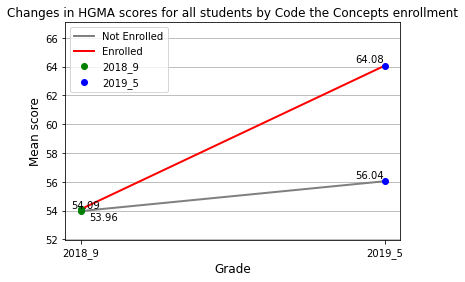

In [23]:
data_source = df_scores_pivot_combined 

i = 140 # Row 140 marks the start of the 4 'Total' rows in the DataFrame.
school_name = data_source.iloc[i,2] 
fig, ax = plt.subplots() # No need to make these plots wider
fig.set_facecolor('white')
fig.set_facecolor('white')
plt.grid(axis = 'y')
xlabels = ['2018-09', '2019-05']

min_val = min(data_source.iloc[i:i+4,5])
max_val = max(data_source.iloc[i:i+4,5])
# print("min_val:",min_val)
# print("max_val:",max_val)
plt.ylim(min_val-2,max_val+3) 

no_line = list(data_source.iloc[[i,i+1],5])
yes_line = list(data_source.iloc[[i+2,i+3],5])

dl_1 = 0
dl_2 = 1

plot_line([dl_1,dl_2],no_line,'gray',line_label='Not Enrolled')
plot_line([dl_1,dl_2],yes_line,'red',line_label='Enrolled',point_label_1=data_source.iloc[i,3],point_label_2 = data_source.iloc[i+1,3])

yoffset = 0 
x_avoid_list = [] 
y_avoid_list = [] 
data_label_list = []
data_label_1 = plt.text(dl_1,data_source.iloc[i,5]-yoffset,'{:.2f}'.format(data_source.iloc[i,5]),ha='center') 
data_label_list.append(data_label_1)
data_label_2 = plt.text(dl_2,data_source.iloc[i+1,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+1,5]),ha='center')
data_label_list.append(data_label_2)
data_label_3 = plt.text(dl_1,data_source.iloc[i+2,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+2,5]),ha='center')
data_label_list.append(data_label_3)
data_label_4 = plt.text(dl_2,data_source.iloc[i+3,5]-yoffset,'{:.2f}'.format(data_source.iloc[i+3,5]),ha='center')
data_label_list.append(data_label_4)
x_avoid = np.linspace(0,1,21) 
y_avoid_1 = data_source.iloc[i,5] + x_avoid*(data_source.iloc[i+1,5] - data_source.iloc[i,5])
y_avoid_2 = data_source.iloc[i+2,5] + x_avoid*(data_source.iloc[i+3,5] - data_source.iloc[i+2,5])
x_avoid += dl_1 # 
# plt.plot(x_avoid, y_avoid_1,color='blue') 
# plt.plot(x_avoid,y_avoid_2,color='black')
x_avoid_list.extend(x_avoid)
y_avoid_list.extend(y_avoid_1)
x_avoid_list.extend(x_avoid)
y_avoid_list.extend(y_avoid_2)
adjust_text(data_label_list, x=x_avoid_list, y=y_avoid_list)
# print("x_avoid_list",x_avoid_list)
# print("y_avoid_list",y_avoid_list)
# plt.plot(x_avoid_list,y_avoid_list,color='black') # Another way of confirming that adjust_text is shifting each text block away from the correct points
plt.title("Changes in HGMA scores for all students by Code the Concepts enrollment")
xtick_list = [dl_1, dl_2]
ax.set_xticks(xtick_list)
ax.set_xticklabels([data_source.iloc[i,3],data_source.iloc[i+1,3]])    
ax.set_ylabel('Mean score',fontsize=12)
ax.set_xlabel('Grade',fontsize=12)

plt.legend()

file_string = 'graphs\\'+school_name+'.png'
plt.savefig(file_string,dpi=400)
plt.show()

In [24]:
end_time = time.time()

run_time = end_time - start_time
run_minutes = int(run_time // 60)
run_seconds = run_time % 60
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only produces an accurate result when the program is run nonstop from start to finish


Total run time: 146.36 second(s) (2 minute(s) and 26.36 second(s))


# Conclusion

I hope this tutorial program will prove helpful for you in your own journeys. This code covered basic descriptive statistics, but being able to quickly and accurately visualize these statistics is a valuable skill--and one for which Python is well suited. Happy coding!